In [1]:
import skimage
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

## harmony
import harmonypy as hm
from scipy.sparse.linalg import svds
import anndata as ad
import scanpy as sc

## 
import glob

import warnings
warnings.filterwarnings('ignore')
from matplotlib.pyplot import figure

In [2]:
evalu = pd.read_csv('../extracted/EvaluationV2.csv')
#evalu = evalu.dropna()

# remove glycans that are not measured in all samples
notinlist = ['Gc_28+S', 'Gc_28+S+Na*2', 'Gc_31+Fuc+Na*2', 'Gc_37+Sx2+Na', 'Gc_48+Sx2+Na',
            'Gc_49+Fucx3', 'Gc_54+Fucx4+Na', '46', '38+Fucx2', 'Gc_8+Fuc']
evalu = evalu[~evalu['composition'].isin(notinlist)]
evalu.head()#.shape

Unnamed: 0.1  Unnamed: 0         peak     lib_mz  matched composition  \
0             0          54   933.318512   933.3170     True           3   
1             2         133  1079.373802  1079.3749     True           4   
2             3         140  1095.374201  1095.3698     True           5   
3             4         226  1257.424853  1257.4226     True           6   
4             5         162  1136.400707  1136.3964     True           8   

   mass_error Note     Standard_name  
0    1.620400  Yes       Hex3HexNAc2  
1    1.017094  Yes  Hex3dHex1HexNAc2  
2    4.017935  Yes       Hex4HexNAc2  
3    1.791732  Yes       Hex5HexNAc2  
4    3.790298  Yes       Hex3HexNAc3

In [3]:
## need meta info

meta = pd.read_csv('../../../meta_link/meta_mibi_dsp.csv')#.dropna()
meta = meta.drop('Unnamed: 9', axis=1).dropna()
meta = meta.loc[:,['location', 'tissueID', 'MALDI-ID']]
meta['treat'] = meta['tissueID'].str[:1]
meta['slide'] = meta['tissueID'].str[:2]
meta = meta.drop_duplicates()
meta.head()

location tissueID MALDI-ID treat slide
1     Small     C1D1     S1-6     C    C1
2     Small     C1D2     S1-5     C    C1
6     Small     C1D3     S1-4     C    C1
13    Large     C1D5     S1-2     C    C1
15    Small     T2D1    S2-13     T    T2

## load harmony corrected version

In [4]:
slides = ['dsst1c1-total_ion_count', 'dsst2c2-total_ion_count',
         'dsst3c3-total_ion_count', 'dsst4c4-total_ion_count']

#slides = ['dsst1c1-total_ion_count']
root_dir = '../extracted/pipeline_results/'
glycogens = evalu.Standard_name.to_list()

####save container
dd = {}
for g in glycogens:
    dd[g]=[]
dd['mid'] = []

idx = 0 
for item in slides:
    idx = idx + 1
    folder_dir = '../extracted/forHarm/'+ item + '/'
    mask_dir = root_dir + item + '/Mask*.tif'
    masklist = glob.glob(mask_dir)
    #masklist = masklist[:1]

    for glyc in glycogens:
        img_dir = folder_dir + glyc + '.tiff'
        img = skimage.io.imread(img_dir)

        ann = []
        for mask in masklist:
            maskid = 'S'+str(idx)+'-'+mask.split('/')[-1][4:-4] # get maskID
            msk = skimage.io.imread(mask) # section mask
            msk[msk > 0] = 1
            img = img + 0.0001# just to keep each mask same size
            img_tmp = img * msk

            ##
            fimg = img_tmp.flatten()
            fimg2 = [i for i in fimg if i != 0]
            dd[glyc].extend(fimg2)
            mmid = [maskid for i in range(len(fimg2))]
            ann.extend(mmid)
    dd['mid'].extend(ann)
    

In [5]:
len(dd[glyc])

2591248

In [6]:
containers = np.zeros((2591248, 38))

idx = 0
for key in dd:
    if idx == 38:
        break
    containers[:,idx] = dd[key]
    idx = idx + 1
containers.shape

(2591248, 38)

In [7]:
df = pd.DataFrame.from_dict(dd)
df.shape

(2591248, 39)

In [8]:
np.random.seed(42)
subidx = np.random.choice(2591248, 25000)

In [9]:

cor_adata = ad.AnnData(
    df.iloc[subidx,:38], dtype=np.float32
)

sc.pp.scale(cor_adata, max_value=10)
sc.tl.pca(cor_adata, svd_solver='arpack')
sc.pp.neighbors(cor_adata, n_neighbors=15, n_pcs=20)
sc.tl.umap(cor_adata)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [10]:
## 
df_meta = df.merge(meta,left_on='mid', right_on='MALDI-ID', how='left')
df_meta.location[df_meta.location.isna()] = 'Human TMA'
df_meta.treat[df_meta.treat.isna()] = 'Human TMA'
#df_meta.slide[df_meta.slide.isna()] = 'Human TMA'
df_meta.head()

Hex3HexNAc2  Hex3dHex1HexNAc2  Hex4HexNAc2  Hex5HexNAc2  Hex3HexNAc3  \
0   134.544092        177.035595     0.000100   427.599515    90.841136   
1    81.102496         55.138908   101.650668   611.031666    97.350853   
2   139.501999        150.493536   163.072734   374.268151   149.089766   
3   102.502195          0.276981   124.732965   473.018665    68.357090   
4   107.062805        140.171859    89.106518   878.891269    83.558495   

   Hex3dHex1HexNAc3  Hex4HexNAc3  Hex3dHex1HexNAc4  Hex5HexNAc3  \
0        280.103008   182.742033        298.009500   264.631626   
1        113.705285   268.790459        212.752240   213.174610   
2        246.993728   242.930179        506.580987   299.119350   
3        144.964745   317.542185        182.542460   126.724180   
4        217.377291   149.959016        162.958661   170.215190   

   Hex5dHex1HexNAc3  ...  Hex4dHex2HexNAc5  Hex6dHex2HexNAc5  \
0        102.573410  ...         91.564577          0.238290   
1        103.693383  ...         40.762668         88.212193   
2        194.931349  ...         88.670187        117.914178   
3        114.621075  ...        126.236962        166.796257   
4        131.188870  ...         12.682013         58.605399   

   Hex5HexNAc6NeuAc1  Hex5HexNAc5NeuAc1   mid  location  tissueID  MALDI-ID  \
0          67.700327          55.613250  S1-9     Large      T1D5      S1-9   
1          98.666084          76.748001  S1-9     Large      T1D5      S1-9   
2         102.892012         199.902934  S1-9     Large      T1D5      S1-9   
3          35.026758          35.866487  S1-9     Large      T1D5      S1-9   
4          66.250073          26.996628  S1-9     Large      T1D5      S1-9   

   treat  slide  
0      T     T1  
1      T     T1  
2      T     T1  
3      T     T1  
4      T     T1  

[5 rows x 44 columns]

In [11]:
## also need to remove pixels will low counts
df2 = df.copy()
df2 = df2.iloc[:,:-1]
df2.loc[:,'Total'] = df2.sum(axis=1)
df2.head()

Hex3HexNAc2  Hex3dHex1HexNAc2  Hex4HexNAc2  Hex5HexNAc2  Hex3HexNAc3  \
0   134.544092        177.035595     0.000100   427.599515    90.841136   
1    81.102496         55.138908   101.650668   611.031666    97.350853   
2   139.501999        150.493536   163.072734   374.268151   149.089766   
3   102.502195          0.276981   124.732965   473.018665    68.357090   
4   107.062805        140.171859    89.106518   878.891269    83.558495   

   Hex3dHex1HexNAc3  Hex4HexNAc3  Hex3dHex1HexNAc4  Hex5HexNAc3  \
0        280.103008   182.742033        298.009500   264.631626   
1        113.705285   268.790459        212.752240   213.174610   
2        246.993728   242.930179        506.580987   299.119350   
3        144.964745   317.542185        182.542460   126.724180   
4        217.377291   149.959016        162.958661   170.215190   

   Hex5dHex1HexNAc3  ...  Hex5HexNAc4NeuAc1  Hex5dHex1HexNAc4NeuAc1  \
0        102.573410  ...          82.176119              105.053276   
1        103.693383  ...         143.707622              194.088920   
2        194.931349  ...          86.188195              218.778415   
3        114.621075  ...          79.506309              166.159314   
4        131.188870  ...          63.144924              190.244881   

   Hex5dHex1HexNAc6NeuAc1  Hex7HexNAc6  Hex5dHex2HexNAc4  Hex4dHex2HexNAc5  \
0               49.831209    38.952591        132.210349         91.564577   
1               93.477850   129.054746         89.271208         40.762668   
2              108.389357    41.780311        173.140242         88.670187   
3               56.325140    49.855558        187.755572        126.236962   
4               62.114967    45.608780        129.394513         12.682013   

   Hex6dHex2HexNAc5  Hex5HexNAc6NeuAc1  Hex5HexNAc5NeuAc1         Total  
0          0.238290          67.700327          55.613250   8867.616196  
1         88.212193          98.666084          76.748001   9488.691164  
2        117.914178         102.892012         199.902934  11515.225156  
3        166.796257          35.026758          35.866487   9129.288598  
4         58.605399          66.250073          26.996628   8043.448734  

[5 rows x 39 columns]

array([[<Axes: title={'center': 'Total'}>]], dtype=object)

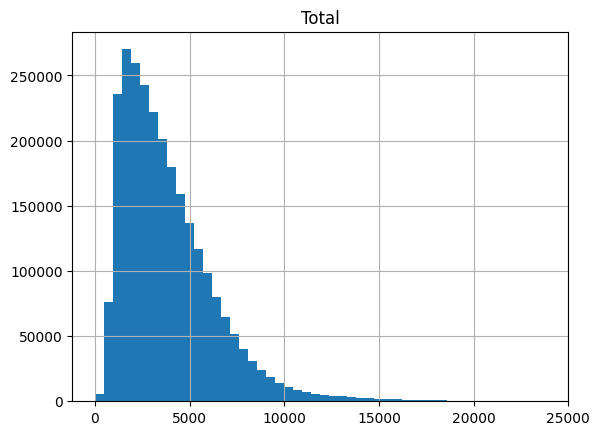

In [12]:
df2.hist(column='Total', bins = 50)

In [14]:
cor_adata

AnnData object with n_obs × n_vars = 25000 × 38
    var: 'mean', 'std'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [15]:
cor_adata.obs['mid'] = df_meta.mid[subidx].to_numpy()
cor_adata.obs['readTot'] = df2.iloc[subidx,:].Total.to_numpy()

#cor_adata_sub = cor_adata[cor_adata.obs['readTot'] > 2000]
#sc.pl.umap(cor_adata_sub, color=['mid'],)

In [16]:
df_meta.treat[subidx].to_numpy()

array(['C', 'C', 'T', ..., 'C', 'Human TMA', 'Human TMA'], dtype=object)

In [22]:
# add object with meta data
cor_adata.obs['treat'] = df_meta.treat[subidx].to_numpy()
cor_adata.obs['readTot'] = df2.iloc[subidx,:].Total.to_numpy()
cor_adata.obs['location'] = df_meta.location[subidx].to_numpy()
cor_adata.obs['slide'] = df_meta.slide[subidx].to_numpy()

## remove control tissue for visualization:
cor_adata_sub = cor_adata[cor_adata.obs['treat'] != 'Human TMA']
cor_adata_sub = cor_adata_sub[cor_adata_sub.obs['readTot'] > 2000] # remove pixels with limited signal

<Figure size 3200x3200 with 0 Axes>

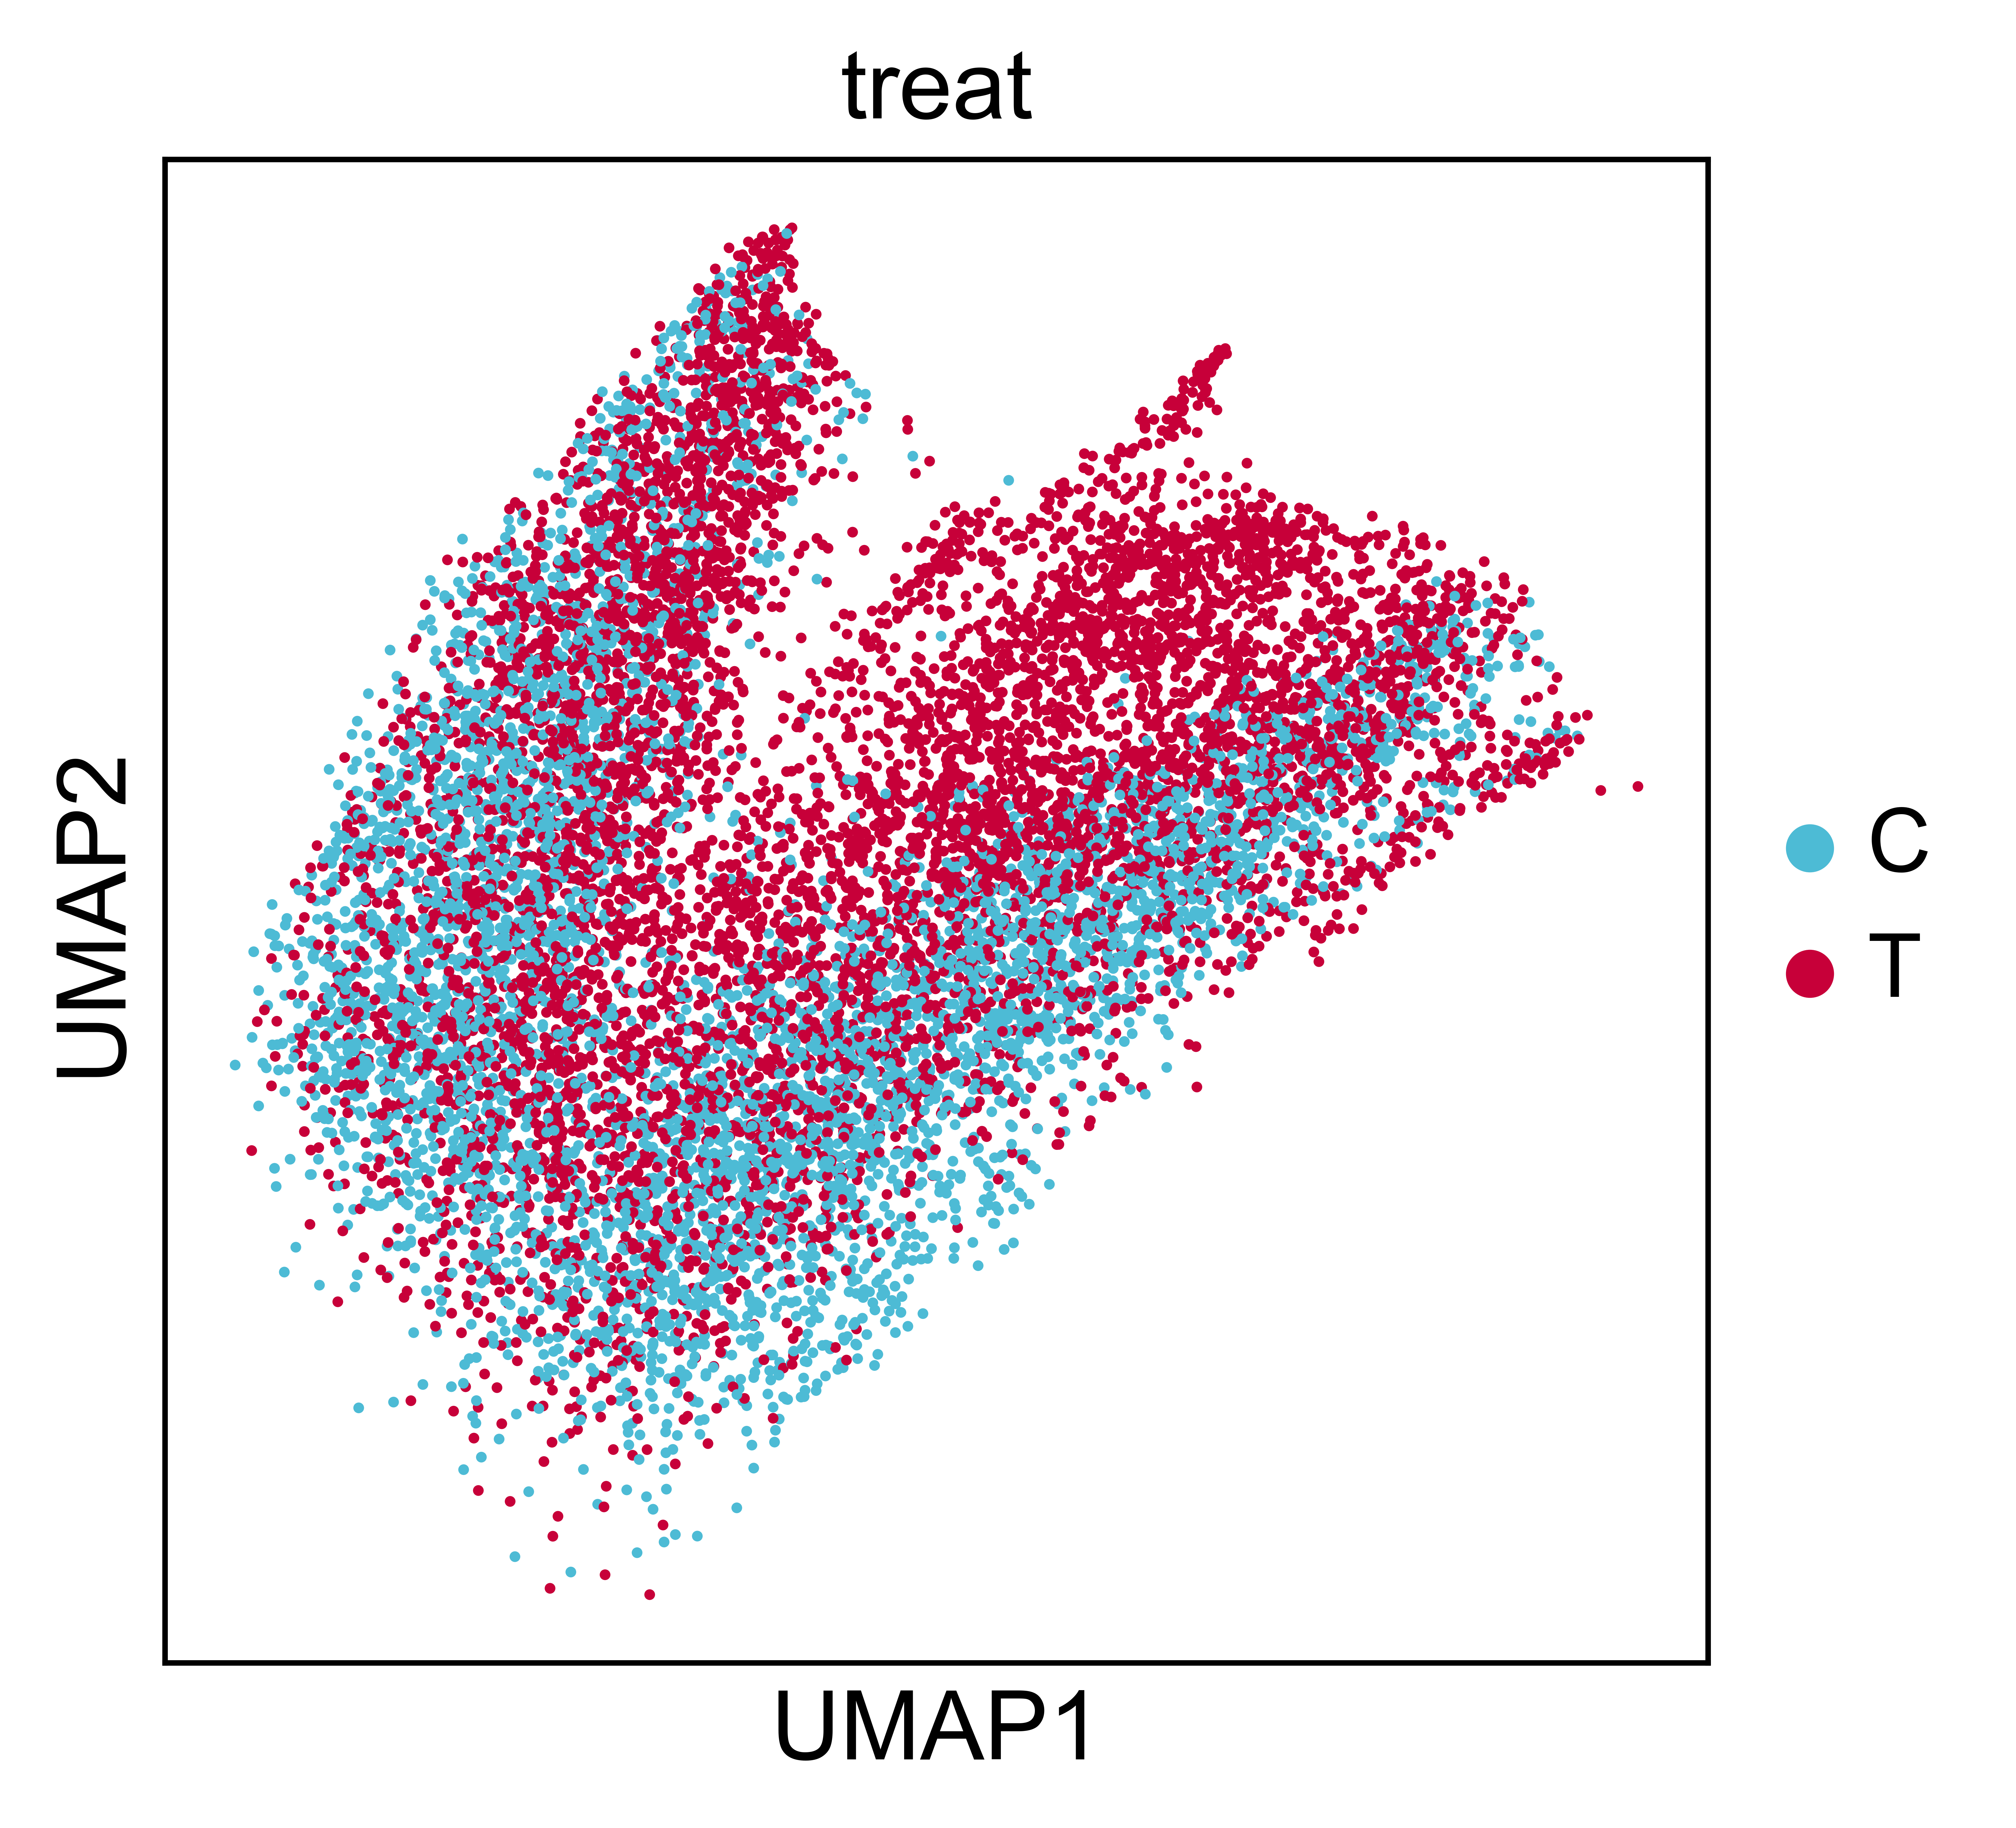

In [23]:
figure(figsize=(4, 4), dpi=800)
sc.set_figure_params(figsize=(4, 4), dpi=800)
with plt.rc_context():  # Use this to set figure params like size and dpi
    sc.pl.umap(cor_adata_sub, color=['treat'],
          palette={'C':'#4DBBD5FF','T':'#C70039','Human TMA':'#B09C85FF'}, show = False)
    plt.savefig("../plots/umap_dss_0228Ver.pdf", bbox_inches="tight")

<Figure size 3200x3200 with 0 Axes>

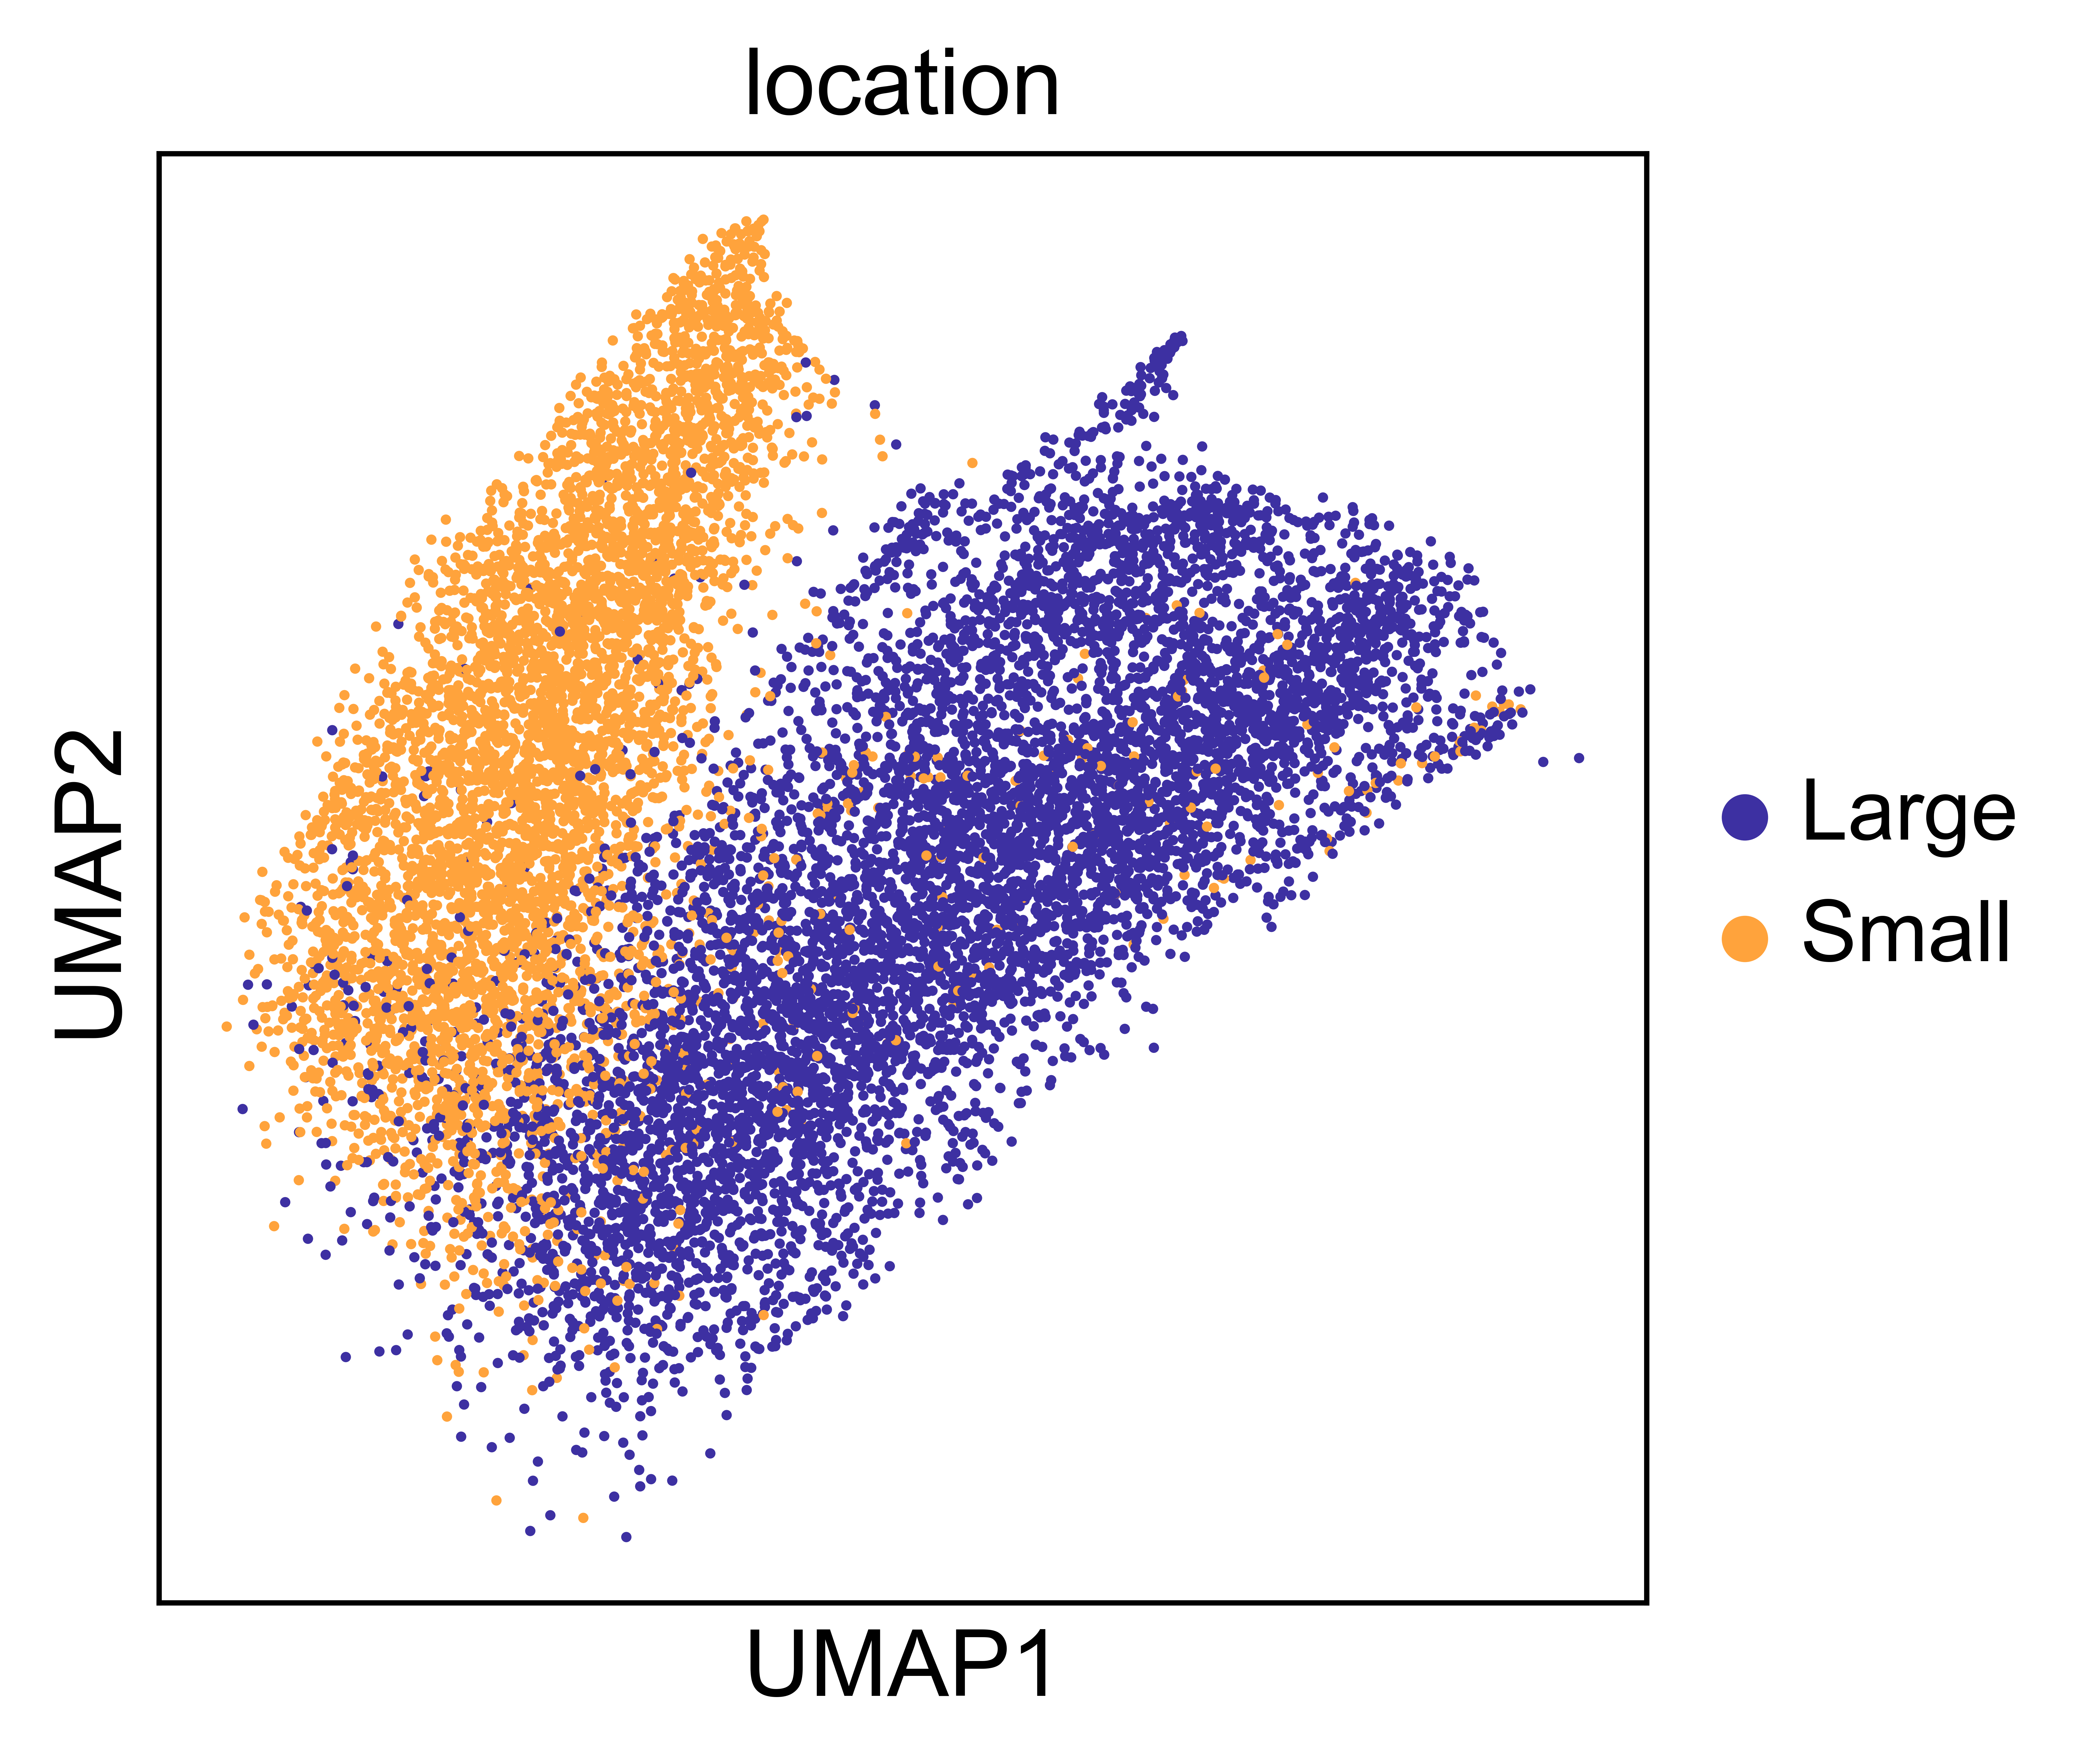

In [24]:
figure(figsize=(4, 4), dpi=800)
sc.set_figure_params(figsize=(4, 4), dpi=800)
with plt.rc_context():  # Use this to set figure params like size and dpi
    sc.pl.umap(cor_adata_sub, color=['location'],
          palette={'Large':'#3D30A2','Small':'#FFA33C','Human TMA':'#B09C85FF'}, show = False)
    plt.savefig("../plots/umap_loc_0228ver.pdf", bbox_inches="tight")

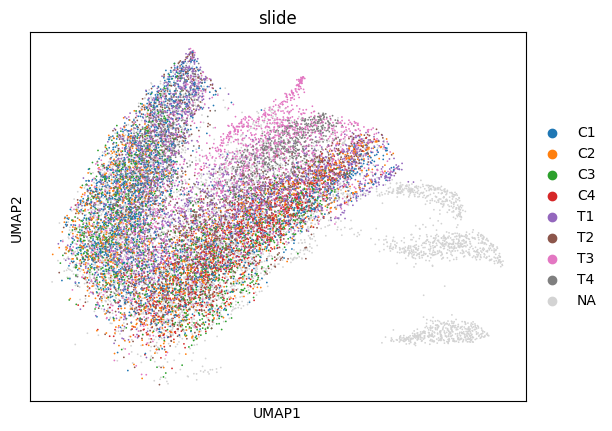

In [194]:
sc.pl.umap(cor_adata_sub, color=['slide'])

In [202]:
## save out
#df_meta_save = df_meta.iloc[subidx,:]
#df_meta_save['umap1'] = cor_adata.obsm['X_umap'][:,0]
#df_meta_save['umap2'] = cor_adata.obsm['X_umap'][:,1]
#df_meta_save['Tot'] = df2.iloc[subidx,:].Total
#df_meta_save.head()

Hex3HexNAc2  Hex3dHex1HexNAc2  Hex4HexNAc2  Hex5HexNAc2  Hex3HexNAc3  \
2219110    88.075076        145.440730    78.132677   279.688843    38.083622   
2229084    58.777618         20.847719    19.692179    75.685603    73.817234   
2356330    89.119246         86.441520    81.238763   474.143048   295.294511   
1692743     4.777611         38.535463    45.462461    83.837477    36.234581   
110268     29.790598         24.676517    24.073879    75.436163    35.262889   

         Hex3dHex1HexNAc3  Hex4HexNAc3  Hex3dHex1HexNAc4  Hex5HexNAc3  \
2219110        110.100277   149.390184        187.007817    77.834930   
2229084         39.686137     3.962672         57.211937     4.282496   
2356330        179.078200   607.563560        226.228585   192.560519   
1692743        114.640844     8.430172         55.041146    15.872505   
110268          58.033634    16.880192         55.904511    17.348430   

         Hex5dHex1HexNAc3  ...  Hex5HexNAc5NeuAc1   mid   location  tissueID  \
2219110         55.241538  ...          78.862609  S4-3      Large      C4D4   
2229084         27.732272  ...          50.343689  S4-3      Large      C4D4   
2356330        110.696778  ...          98.041867  S4-7      Large      T4D6   
1692743         34.020521  ...          51.838586  S3-2  Human TMA       NaN   
110268          44.875174  ...          70.020387  S1-1  Human TMA       NaN   

         MALDI-ID      treat  slide     umap1      umap2          Tot  
2219110      S4-3          C     C4  3.018916  12.339486  5502.918655  
2229084      S4-3          C     C4 -3.681389   3.071199  1028.014621  
2356330      S4-7          T     T4  3.306550  14.581225  7568.495081  
1692743       NaN  Human TMA    NaN -2.609670   5.297016  1560.451253  
110268        NaN  Human TMA    NaN -3.893723   4.896363  1402.339411  

[5 rows x 47 columns]

In [203]:
#df_meta_save.to_csv('../data/umap_meta_saveout_0228.csv')